In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error as mse

In [39]:
d = 8
n = 8
beta1s = 3
beta = np.asarray([1]*beta1s + [0]*(d-beta1s))

thresh = n

dd_all_train = []
dd_all_test = []
dd_all_alphas = []
dd_all_bics = []

sd_all_train = []
sd_all_test = []
sd_all_alphas = []
sd_all_bics = []

for i in range(50):
    np.random.seed(i)
    X_train = np.random.normal(0, 1, (n, d))
    y_train = X_train @ beta.T + np.random.normal(0, 0.1, (n,))
    X_test = np.random.normal(0, 1, (10000, d))
    y_test = X_test @ beta.T + np.random.normal(0, 0.1, (10000,))

    dd_train_error = []
    dd_test_error = []
    dd_alphas = []
    dd_bics = []
    for p in range(1, thresh+1):
        lr = LinearRegression(fit_intercept=False).fit(X_train[:, :p], y_train)
        dd_train_error.append(mse(y_train, lr.predict(X_train[:, :p])))
        dd_test_error.append(mse(y_test, lr.predict(X_test[:, :p])))
        dd_alphas.append(0)
        dd_bics.append(n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (1 + p) * np.log(n))

    for p in range(thresh, d+1):
        lr = RidgeCV(fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-2, 2, 20)).fit(X_train[:, :p], y_train)
        dd_train_error.append(mse(y_train, lr.predict(X_train[:, :p])))
        dd_test_error.append(mse(y_test, lr.predict(X_test[:, :p])))
        dd_alphas.append(lr.alpha_)
        dd_bics.append(n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (2 + p) * np.log(n))
    
    dd_all_train.append(dd_train_error)
    dd_all_test.append(dd_test_error)
    dd_all_alphas.append(dd_alphas)
    dd_all_bics.append(dd_bics)
    
    sd_train_error = []
    sd_test_error = []
    sd_alphas = []
    sd_bics = []
    for p in range(1, d+1):
        lr = RidgeCV(fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-2, 2, 20)).fit(X_train[:, :p], y_train)
        # lr = LassoCV(fit_intercept=False, alphas=np.logspace(-4, 4, 20)).fit(X_train[:, :p], y_train)
        sd_train_error.append(mse(y_train, lr.predict(X_train[:, :p])))
        sd_test_error.append(mse(y_test, lr.predict(X_test[:, :p])))
        sd_alphas.append(lr.alpha_)
        sd_bics.append(n * np.log(mse(y_train, lr.predict(X_train[:, :p]))) + (2 + p) * np.log(n))

    sd_all_alphas.append(sd_alphas)
    sd_all_train.append(sd_train_error)
    sd_all_test.append(sd_test_error)
    sd_all_bics.append(sd_bics)
    
# dd

df_dd = pd.DataFrame(dd_all_test).melt(var_name='Number of Model Parameters', value_name='Generalization MSE')
df_dd['Number of Model Parameters'] += 1

df_dd_alphas = pd.DataFrame(dd_all_alphas).melt(var_name='Number of Model Parameters', value_name='lambda')
df_dd_alphas['Number of Model Parameters'] += 1

df_dd_bics = pd.DataFrame(dd_all_bics).melt(var_name='Number of Model Parameters', value_name='BIC')
df_dd_bics['Number of Model Parameters'] += 1

df_dd = pd.concat((df_dd, df_dd_alphas['lambda'], df_dd_bics['BIC']), axis=1)

# sd

df_sd = pd.DataFrame(sd_all_test).melt(var_name='Number of Model Parameters', value_name='Generalization MSE')
df_sd['Number of Model Parameters'] += 2

df_sd_alphas = pd.DataFrame(sd_all_alphas).melt(var_name='Number of Model Parameters', value_name='lambda')
df_sd_alphas['Number of Model Parameters'] += 2

df_sd_bics = pd.DataFrame(sd_all_bics).melt(var_name='Number of Model Parameters', value_name='BIC')
df_sd_bics['Number of Model Parameters'] += 2

df_sd = pd.concat((df_sd, df_sd_alphas['lambda'], df_sd_bics['BIC']), axis=1)

In [3]:
curve_interp = interp1d(n_params, regs)
color_interp = interp1d(n_params, errors)
cap_range = np.linspace(n_params[0], n_params[-1], 1000)
reg_range = curve_interp(cap_range)
color_range = color_interp(cap_range)

NameError: name 'interp1d' is not defined

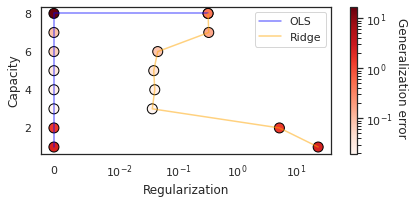

In [55]:
sns.set_style('white')
f, ax = plt.subplots(1, 1, figsize=(6, 3))

_, dd_errors, _ = df_dd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
_, sd_errors, _ = df_sd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
max_error = np.max(np.concatenate((dd_errors, sd_errors)))


n_params, errors, regs = df_dd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
n_params[-1] -= 1

ax.plot(regs, n_params, ls='-', c='blue', label='OLS', alpha=0.5)
sc = ax.scatter(
    regs, n_params, c=errors, vmax=max_error, vmin=min_error,#cm.Reds(np.log(errors) / np.log(max_error)),
    s=100, edgecolor='black', cmap='Reds', norm=matplotlib.colors.LogNorm(),)

n_params, errors, regs = df_sd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
n_params -= 1

ax.plot(regs, n_params, ls='-', c='orange', label='Ridge', alpha=0.5)
sc = ax.scatter(
    regs, n_params, c=errors, vmax=max_error, vmin=min_error,#cm.Reds(np.log(errors) / np.log(max_error)),
    s=100, edgecolor='black', cmap='Reds', norm=matplotlib.colors.LogNorm(),)

cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Generalization error ', rotation=270, labelpad=15)

plt.xscale('symlog', linthreshx=1e-2)
plt.xlabel('Regularization')
plt.ylabel('Capacity')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/ols_vs_ridge_traversal_scatter.pdf')
plt.show()

In [28]:
from scipy.interpolate import interp1d
from matplotlib import cm
import matplotlib

## Capacity vs Reg

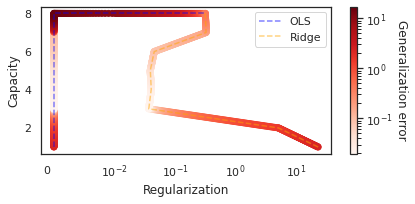

In [52]:
sns.set_style('white')
f, ax = plt.subplots(1, 1, figsize=(6, 3))

_, dd_errors, _ = df_dd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
_, sd_errors, _ = df_sd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
max_error = np.max(np.concatenate((dd_errors, sd_errors)))
min_error = np.min(np.concatenate((dd_errors, sd_errors)))

# OLS
n_params, errors, regs = df_dd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
n_params[-1] -= 1

regs += 0.001

reg_coords = np.asarray([])
cap_coords = np.asarray([])
color_vals = np.asarray([])
res = 100
for i in range(len(n_params) - 1):
    reg_coords = np.append(reg_coords, np.exp(np.linspace(np.log(regs[i]), np.log(regs[i+1]), 100)))
    cap_coords = np.append(cap_coords, np.linspace(n_params[i], n_params[i+1], 100))
    color_vals = np.append(color_vals, np.linspace(errors[i], errors[i+1], 100))

ax.plot(reg_coords, cap_coords, ls='--', c='Blue', label='OLS', alpha=0.5)
sc = ax.scatter(
    reg_coords,
    cap_coords,
    c = color_vals,
    vmax = max_error,
    vmin = min_error,
    cmap='Reds',
    norm=matplotlib.colors.LogNorm(),
)
    
# Ridge
n_params, errors, regs = df_sd.groupby('Number of Model Parameters').mean().reset_index().to_numpy().T
n_params -= 1
regs += 0.001

reg_coords = np.asarray([])
cap_coords = np.asarray([])
color_vals = np.asarray([])
res = 100
for i in range(len(n_params) - 1):
    reg_coords = np.append(reg_coords, np.exp(np.linspace(np.log(regs[i]), np.log(regs[i+1]), 100)))
    cap_coords = np.append(cap_coords, np.linspace(n_params[i], n_params[i+1], 100))
    color_vals = np.append(color_vals, np.linspace(errors[i], errors[i+1], 100))

ax.plot(reg_coords, cap_coords, ls='--', c='orange', label='Ridge', alpha=0.5)
sc = ax.scatter(
    reg_coords,
    cap_coords,
#     c = np.log(color_vals),
#     vmax = np.log(max_error),
#     vmin = np.log(min_error),
    c = color_vals,
    vmax = max_error,
    vmin = min_error,
    cmap='Reds',
    norm=matplotlib.colors.LogNorm(),
)

cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Generalization error', rotation=270, labelpad=15)

plt.xscale('symlog', linthreshx=1e-2)
plt.xlabel('Regularization')
plt.ylabel('Capacity')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/ols_vs_ridge_traversal_interp.pdf')
plt.show()

## n params vs capacity

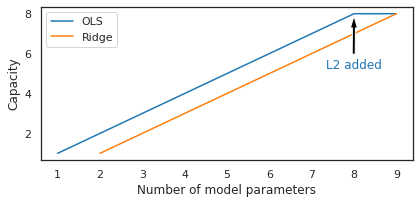

In [24]:
sns.set_style('white')
sns.set_context('notebook')

f, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot([1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,8], label='OLS')
ax.plot([2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8], label='Ridge')

# ax.text(0.78, 0.86, 'l2 added', horizontalalignment='center', c=ax.get_lines()[0].get_c(),
#          verticalalignment='center', transform=ax.transAxes)

ax.annotate('L2 added', xy=(8, 8),  xycoords='data',
            xytext=(0.84, 0.66), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=7),
            horizontalalignment='center', verticalalignment='top',
            c=ax.get_lines()[0].get_c()
            )

ax.set_ylabel('Capacity')
ax.set_xlabel(r'Number of model parameters')
plt.legend()
plt.tight_layout()
# plt.savefig('./figures/linear_capacity_vs_params.pdf')
plt.show()

In [59]:
df_sd.groupby('Number of Model Parameters').mean()

,Generalization MSE,lambda,BIC
Number of Model Parameters,,,
2,2.449367,23.211617,9.011075
3,1.453067,5.115904,3.289142
4,0.020128,0.035931,-31.284228
5,0.023957,0.039576,-31.271003
6,0.038330,0.038022,-32.335028
7,0.084142,0.044411,-34.572601
8,0.158829,0.325032,-38.296558
9,0.433094,0.316314,-41.761194


## BIC

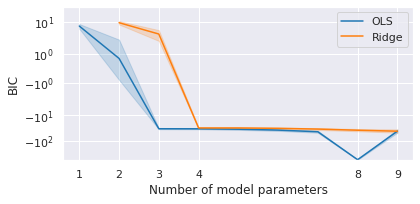

In [61]:
sns.set_style('darkgrid')
sns.set_context('notebook')

f, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(data=df_dd, x='Number of Model Parameters', y='BIC', ax=ax, label='OLS')
sns.lineplot(data=df_sd, x='Number of Model Parameters', y='BIC', ax=ax, label='Ridge')
ax.set_xticks([1, 2, 3, 4, n, n+1])
ax.set_xticklabels([1, 2, 3, 4, '8', n+1])
# ax.axvline(n, label='Sample size', ls=':', c='black', lw=2)

# plt.title(f'Regression double descent (d={d}, n={n})')
plt.yscale('symlog')

ax.legend()
# ax.legend(bbox_to_anchor=(1.0, 1), loc="upper left")
# ax.axvline(n, ls=':', c='black', ymax=0.8)
# ax.text(0.78, 0.86, 'p=n', horizontalalignment='center', c=ax.get_lines()[0].get_c(),
#          verticalalignment='center', transform=ax.transAxes)

# # ax.axvline(10, ls=':', c='black', ymax=0.5)
# # ax.text(0.85, 0.55, 'd', horizontalalignment='center',
# #          verticalalignment='center', transform=ax.transAxes)

# # ax.axvline(n+1, ls=':', c='black', ymax=0.4)
# ax.text(0.925, 0.15, 'l2 added\n(p=n)', horizontalalignment='center', c=ax.get_lines()[0].get_c(),
#          verticalalignment='center', transform=ax.transAxes)#, fontsize=12)
# ax.scatter(8, df_dd[df_dd['Number of Model Parameters'] == 8]['BIC'].mean(), c='black')
# ax.scatter(9, df_dd[df_dd['Number of Model Parameters'] == 9]['BIC'].mean(), c='black')
ax.set_xlabel(r'Number of model parameters')
ax.set_yticks([10, 1, -1, -10, -100])

# ax.axvline(8, ls='--', label='OLS min', c=ax.get_lines()[0].get_c())

plt.tight_layout()
plt.savefig('./figures/ols_vs_ridge_bic.pdf')
plt.show()

## MSE vs params

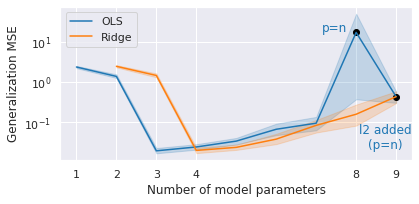

In [51]:
sns.set_style('darkgrid')
sns.set_context('notebook')

f, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(data=df_dd, x='Number of Model Parameters', y='Generalization MSE', ax=ax, label='OLS')
sns.lineplot(data=df_sd, x='Number of Model Parameters', y='Generalization MSE', ax=ax, label='Ridge')
ax.set_xticks([1, 2, 3, 4, n, n+1])
ax.set_xticklabels([1, 2, 3, 4, '8', n+1])
# ax.axvline(n, label='Sample size', ls=':', c='black', lw=2)

# plt.title(f'Regression double descent (d={d}, n={n})')
plt.yscale('log')

ax.legend(loc="upper left")
# ax.legend(bbox_to_anchor=(1.0, 1), loc="upper left")
# ax.axvline(n, ls=':', c='black', ymax=0.8)
ax.text(0.78, 0.86, 'p=n', horizontalalignment='center', c=ax.get_lines()[0].get_c(),
         verticalalignment='center', transform=ax.transAxes)

# ax.axvline(10, ls=':', c='black', ymax=0.5)
# ax.text(0.85, 0.55, 'd', horizontalalignment='center',
#          verticalalignment='center', transform=ax.transAxes)

# ax.axvline(n+1, ls=':', c='black', ymax=0.4)
ax.text(0.925, 0.15, 'l2 added\n(p=n)', horizontalalignment='center', c=ax.get_lines()[0].get_c(),
         verticalalignment='center', transform=ax.transAxes)#, fontsize=12)
ax.scatter(8, df_dd[df_dd['Number of Model Parameters'] == 8]['Generalization MSE'].mean(), c='black')
ax.scatter(9, df_dd[df_dd['Number of Model Parameters'] == 9]['Generalization MSE'].mean(), c='black')
ax.set_xlabel(r'Number of model parameters')

plt.tight_layout()
plt.savefig('./figures/ols_vs_ridge_double_descent.pdf')
plt.show()

In [2]:
d = 10
beta1s = 3
beta = np.asarray([1]*beta1s + [0]*(d-beta1s))

threshs = [0, 10] # list(range(0, d+1))
eps_var = np.sqrt(0.1)

n = 9
gen_error_n9 = defaultdict(list)
norm_n9 = defaultdict(list)

for i in range(100):
    np.random.seed(i)
    X_train = np.random.normal(0, 1, (n, d))
    y_train = X_train @ beta.T + np.random.normal(0, eps_var, (n,))
    X_test = np.random.normal(0, 1, (10000, d))
    y_test = X_test @ beta.T + np.random.normal(0, eps_var, (10000,))

    for thresh in threshs:
        gen_error_n9[thresh].append([])
        norm_n9[thresh].append([])
        for p in range(1, thresh+1):
            lr = LinearRegression(fit_intercept=False).fit(X_train[:, :p], y_train)
            gen_error_n9[thresh][-1].append(mse(y_test, lr.predict(X_test[:, :p])))
            norm_n9[thresh][-1].append(np.linalg.norm(lr.coef_))
        for p in range(thresh, d+1):
            if p <= 0:
                continue
            lr = RidgeCV(
                fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-3, 3, 100)
            ).fit(X_train[:, :p], y_train)
            gen_error_n9[thresh][-1].append(mse(y_test, lr.predict(X_test[:, :p])))
            norm_n9[thresh][-1].append(np.linalg.norm(lr.coef_))
            
n = 8
gen_error_n8 = defaultdict(list)
norm_n8 = defaultdict(list)
for i in range(100):
    np.random.seed(i)
    X_train = np.random.normal(0, 1, (n, d))
    y_train = X_train @ beta.T + np.random.normal(0, eps_var, (n,))
    X_test = np.random.normal(0, 1, (10000, d))
    y_test = X_test @ beta.T + np.random.normal(0, eps_var, (10000,))

    for thresh in threshs:
        gen_error_n8[thresh].append([])
        norm_n8[thresh].append([])
        for p in range(1, thresh+1):
            lr = LinearRegression(fit_intercept=False).fit(X_train[:, :p], y_train)
            gen_error_n8[thresh][-1].append(mse(y_test, lr.predict(X_test[:, :p])))
            norm_n8[thresh][-1].append(np.linalg.norm(lr.coef_))
        for p in range(thresh, d+1):
            if p <= 0:
                continue
            lr = RidgeCV(
                fit_intercept=False, scoring='neg_mean_squared_error', alphas=np.logspace(-3, 3, 100)
            ).fit(X_train[:, :p], y_train)
            gen_error_n8[thresh][-1].append(mse(y_test, lr.predict(X_test[:, :p])))
            norm_n8[thresh][-1].append(np.linalg.norm(lr.coef_))

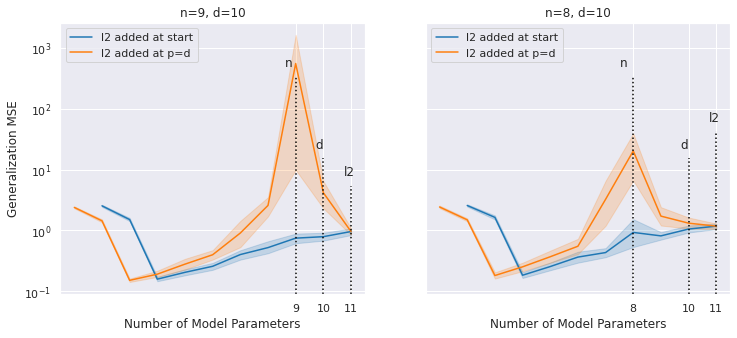

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for key, val in gen_error_n9.items():
    df = pd.DataFrame(val).melt(var_name='Number of Model Parameters', value_name='Generalization MSE')
    if key == 0:
        df['Number of Model Parameters'] += 2
    else:
        df['Number of Model Parameters'] += 1
    if key == 0:
        label = 'l2 added at start'
    else:
        label = 'l2 added at p=d'
    sns.lineplot(data=df, x='Number of Model Parameters', y='Generalization MSE', ax=ax1, label=label)
    
for key, val in gen_error_n8.items():
    df = pd.DataFrame(val).melt(var_name='Number of Model Parameters', value_name='Generalization MSE')
    if key == 0:
        df['Number of Model Parameters'] += 2
    else:
        df['Number of Model Parameters'] += 1
    if key == 0:
        label = 'l2 added at start'
    else:
        label = 'l2 added at p=d'
    sns.lineplot(data=df, x='Number of Model Parameters', y='Generalization MSE', ax=ax2, label=label)

ax1.legend(loc="upper left")
ax1.set_xticks([9, 10, 11])
ax1.axvline(9, label='n=9', ls=':', c='black', ymax=0.8)
ax1.text(0.75, 0.85, 'n', horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)

ax1.axvline(10, label='d=10', ls=':', c='black', ymax=0.5)
ax1.text(0.85, 0.55, 'd', horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)

ax1.axvline(11, label='n=9', ls=':', c='black', ymax=0.4)
ax1.text(0.95, 0.45, 'l2', horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)
ax1.set_title('n=9, d=10')

ax2.legend(loc="upper left")
ax2.set_xticks([8, 10, 11])
ax2.axvline(8, label='n=9', ls=':', c='black', ymax=0.8)
ax2.text(0.65, 0.85, 'n', horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes)

ax2.axvline(10, label='d=10', ls=':', c='black', ymax=0.5)
ax2.text(0.85, 0.55, 'd', horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes)

ax2.axvline(11, label='n=9', ls=':', c='black', ymax=0.6)
ax2.text(0.95, 0.65, 'l2', horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes)
ax2.set_title('n=8, d=10')
# plt.ylim([0, 10])
ax1.set_yscale('log')
ax2.set_yscale('log')

plt.show()

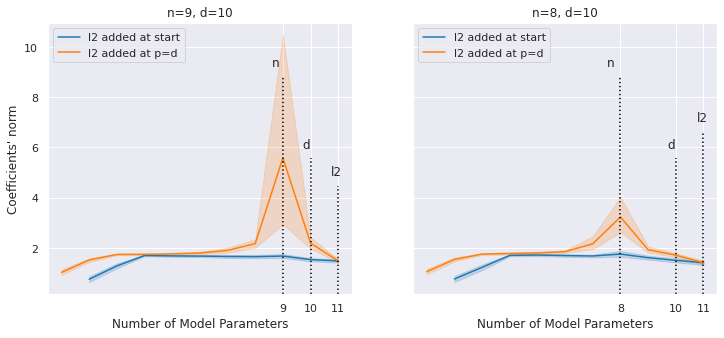

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for key, val in norm_n9.items():
    df = pd.DataFrame(val).melt(var_name='Number of Model Parameters', value_name='Coefficients\' norm')
    if key == 0:
        df['Number of Model Parameters'] += 2
    else:
        df['Number of Model Parameters'] += 1
    if key == 0:
        label = 'l2 added at start'
    else:
        label = 'l2 added at p=d'
    sns.lineplot(data=df, x='Number of Model Parameters', y='Coefficients\' norm', ax=ax1, label=label)
    
for key, val in norm_n8.items():
    df = pd.DataFrame(val).melt(var_name='Number of Model Parameters', value_name='Coefficients\' norm')
    if key == 0:
        df['Number of Model Parameters'] += 2
    else:
        df['Number of Model Parameters'] += 1
    if key == 0:
        label = 'l2 added at start'
    else:
        label = 'l2 added at p=d'
    sns.lineplot(data=df, x='Number of Model Parameters', y='Coefficients\' norm', ax=ax2, label=label)

ax1.legend(loc="upper left")
ax1.set_xticks([9, 10, 11])
ax1.axvline(9, label='n=9', ls=':', c='black', ymax=0.8)
ax1.text(0.75, 0.85, 'n', horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)

ax1.axvline(10, label='d=10', ls=':', c='black', ymax=0.5)
ax1.text(0.85, 0.55, 'd', horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)

ax1.axvline(11, label='n=9', ls=':', c='black', ymax=0.4)
ax1.text(0.95, 0.45, 'l2', horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes)
ax1.set_title('n=9, d=10')

ax2.legend(loc="upper left")
ax2.set_xticks([8, 10, 11])
ax2.axvline(8, label='n=9', ls=':', c='black', ymax=0.8)
ax2.text(0.65, 0.85, 'n', horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes)

ax2.axvline(10, label='d=10', ls=':', c='black', ymax=0.5)
ax2.text(0.85, 0.55, 'd', horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes)

ax2.axvline(11, label='n=9', ls=':', c='black', ymax=0.6)
ax2.text(0.95, 0.65, 'l2', horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes)
ax2.set_title('n=8, d=10')

plt.show()